In [364]:
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from langchain_aws import BedrockEmbeddings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [365]:
df = pd.read_csv('data/raw/dataset.csv')

In [366]:
def look_dataset(df) -> None:
    print('First few columns of Dataset:')
    print(df.head())
    print("-----")
    print("Dataset Information:")
    print(df.info())
    print("-----")
    print("Features Summary Statistics")
    print(df.describe())
    

In [367]:
look_dataset(df)

First few columns of Dataset:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again         

### Checking for Possible Duplicates

In [368]:
df['track_id'].value_counts()

track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
5ZsAhuQ24mWHiduaxJqnhW    7
08kTa3SL9sV6Iy8KLKtGql    7
                         ..
0kJ7eKX6aWl8X1W5Xrosn6    1
4bYH5445Bn2w9UiGM0NxQw    1
1T5C6ENvpM3IiYeezsK9uI    1
34SatKRJgtXfL0bcgk7HMA    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: count, Length: 89741, dtype: int64

In [369]:
df[['artists','track_name']].value_counts()

artists                                                 track_name                               
Chuck Berry                                             Run Rudolph Run                              151
The Beach Boys                                          Little Saint Nick - 1991 Remix                76
Burna Boy                                               Last Last                                     75
Ella Fitzgerald                                         Frosty The Snowman                            69
Bryan Adams                                             Christmas Time                                66
                                                                                                    ... 
Hillsong Worship;TAYA                                   Upper Room - Studio                            1
                                                        Valentine - Live                               1
Hillsong Worship;TAYA;David Ware                        Fresh 

Observe that there are repeated entries for `track_id` and the key(`artists`,  `track_name`)

In [370]:
# Process Dataframe
df = df.iloc[:,1:] 
df = df.drop_duplicates(['artists','track_name']) # Duplicate Values

In [371]:
df['track_id'].value_counts()

track_id
5SuOikwiRyPMVoIQDJUgSV    1
6WaYiQUPel70HUaCZj5eND    1
060RNnzoMay3wKJek1faPc    1
2qjH6wZfR0g11ZiT7KqyRO    1
3Ddgh4ZwVIkLx0f4WeDFmo    1
                         ..
1ufGqwim7RHxVsdaxuLmAY    1
2Xm7PDrm7BjRbqMsnwWUla    1
7rBZUdVNrNxucV0E3bjgec    1
3hezVtcUqncXSpBbV4dTCQ    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: count, Length: 81344, dtype: int64

Removing duplicates for the key(`artists`,  `track_name`) also removed duplicates for the `track_id`

### Checking for Possible Missing Values

In [372]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [373]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
print(rows_with_missing_values)

                     track_id artists album_name track_name  popularity  \
65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN           0   

       duration_ms  explicit  danceability  energy  key  loudness  mode  \
65900            0     False         0.501   0.583    7     -9.46     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
65900       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature track_genre  
65900  138.391               4       k-pop  


All the missing values came from one entry so we should remove this entry

In [374]:
# Process Dataframe
df = df.dropna()

In [375]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Variables `popularity` and `duration_ms` could possibly be split into groups!

### Running KMeans for `popularity`

In [376]:
# Scale Data
popularity = df[['popularity']]
popularity_scaler = StandardScaler()
popularity_scaled = popularity_scaler.fit_transform(popularity)

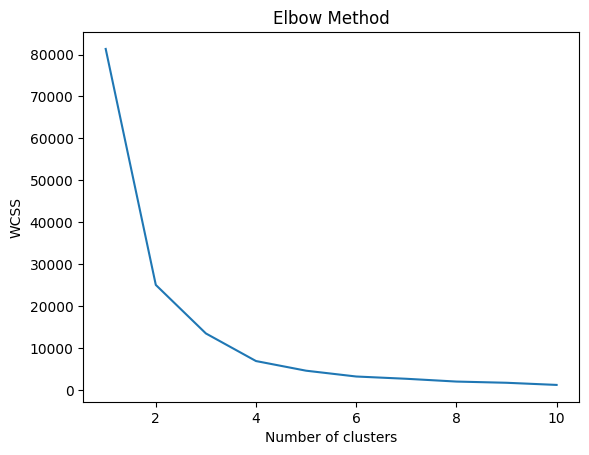

In [377]:
# Determine Number of Clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(popularity_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

By Elbow Method, we choose k = 4

In [378]:
def cluster_popularity(df):
    # Scale Data
    popularity = df[['popularity']]
    popularity_scaler = StandardScaler()
    popularity_scaled = popularity_scaler.fit_transform(popularity)

    # Run K-means with the optimal number of clusters, reorder clusters to popularity
    optimal_clusters = 4 
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    df['popularity_clusters'] = kmeans.fit_predict(popularity_scaled)
    cluster_means = df.groupby('popularity_clusters')['popularity'].mean()
    sorted_clusters = cluster_means.sort_values().index
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
    df['popularity_clusters'] = df['popularity_clusters'].map(cluster_mapping)

    return df

df = cluster_popularity(df)

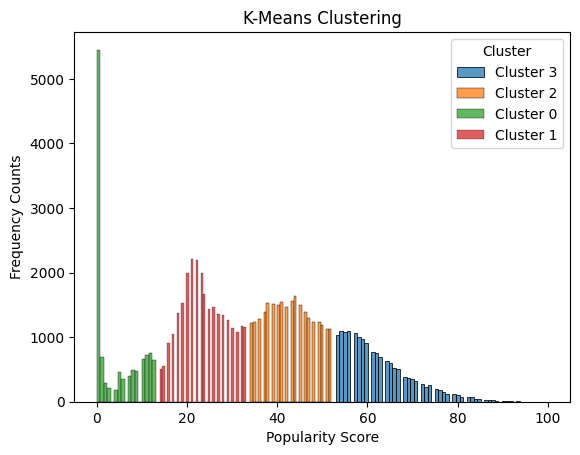

In [379]:
for cluster in df['popularity_clusters'].unique():
    sns.histplot(df[df['popularity_clusters'] == cluster]['popularity'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency Counts')
plt.legend(title='Cluster')
plt.show()

### Running KMeans for `duration_ms`

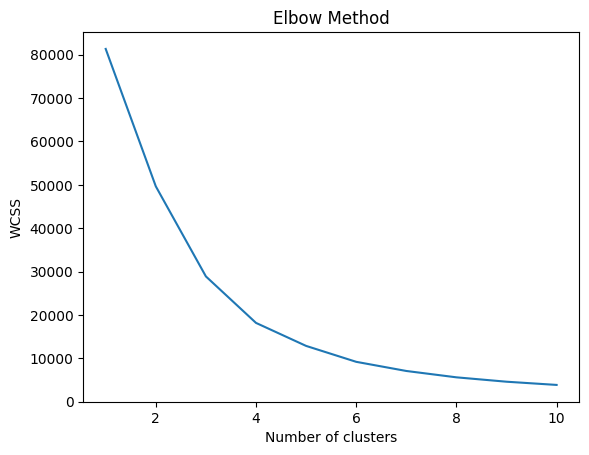

In [380]:
# Scale Data
duration_ms= df[['duration_ms']]
scaler = StandardScaler()
duration_ms_scaled = scaler.fit_transform(duration_ms)

# Determine Number of Clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(duration_ms_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

By Elbow Method, we choose k = 6

In [381]:
def cluster_duration_ms(df):
    duration_ms= df[['duration_ms']]
    scaler = StandardScaler()
    duration_ms_scaled = scaler.fit_transform(duration_ms)

    optimal_clusters = 6 
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    df['duration_clusters'] = kmeans.fit_predict(duration_ms_scaled)
    cluster_means = df.groupby('duration_clusters')['duration_ms'].mean()
    sorted_clusters = cluster_means.sort_values().index
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
    df['duration_clusters'] = df['duration_clusters'].map(cluster_mapping)
    
    return df

cluster_duration_ms(df)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_clusters,duration_clusters
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,3,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,3,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,3,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,3,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,...,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,1,3
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,...,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,1,3
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,...,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,1,2
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,...,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,2,2


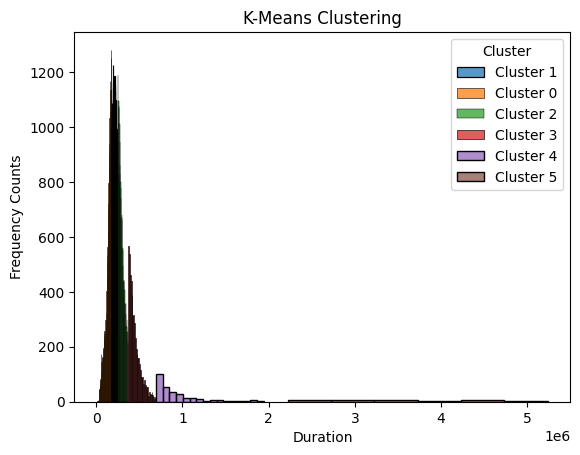

In [382]:
for cluster in df['duration_clusters'].unique():
    sns.histplot(df[df['duration_clusters'] == cluster]['duration_ms'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('Duration')
plt.ylabel('Frequency Counts')
plt.legend(title='Cluster')
plt.show()

### Processing `track_genre` feature
Idea is to convert genre into vector embeddings

In [383]:
def embed_track_genre(df):
    embeddings = BedrockEmbeddings()
    embeddings_list = []

    for genre in df['track_genre']:
        embedding = embeddings.embed_query(genre)
        embeddings_list.append(embedding)

    embeddings_df = pd.DataFrame(embeddings_list, columns=[f'embedding_{i}' for i in range(len(embeddings_list[0]))])
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)
    print(df_with_embeddings)
    return df_with_embeddings
